### Imports

In [60]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### File handling

In [61]:
def load_data(file_path):
    data = pd.read_csv(file_path, index_col=0)
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)
    return data


### Balancing Data For No Bias

In [62]:
def balance_data(data):
    gamma_data = data[data['class']=='g']
    hadron_data = data[data['class']=='h']
    min_size = min(len(gamma_data), len(hadron_data))
    balanced_gamma = gamma_data.sample(n=min_size, random_state=42)
    balanced_hadron = hadron_data.sample(n=min_size, random_state=42)
    balanced_data = pd.concat([balanced_gamma, balanced_hadron])
    balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced_data

### Data Splitting For Training, Validation & Testing

In [63]:
def training_data_set(data):
    train_size = int(0.7 * len(data))
    training_data = data.iloc[:train_size].reset_index(drop=True)
    return training_data

def validation_data_set(data):
    val_size = int(0.15 * len(data))
    validation_data = data.iloc[int(0.7 * len(data)):int(0.7 * len(data)) + val_size].reset_index(drop=True)
    return validation_data

def test_data_set(data):
    test_size = int(0.15 * len(data))
    test_data = data.iloc[int(0.85 * len(data)):].reset_index(drop=True)
    return test_data

### K-NN Manual Logic


In [64]:
def distance_calculation(data1, data2):
    return np.sqrt(np.sum((data1 - data2) ** 2))

def K_Nearest_Neighbors_Manual(data, k, test_sample):
    distances =[]
    for data1 in data.values:
        data_train = data1[:-1]
        dist = distance_calculation(data_train, test_sample)
        label = data1[-1]
        distances.append((dist, label))
        
    distances.sort(key=lambda x: x[0])
    neighbors = distances[:k]
    gamma_count = sum(1 for neighbor in neighbors if neighbor[1] == 'g')
    hadron_count = k - gamma_count
    if gamma_count > hadron_count:
        return 'g'
    return 'h'

### K-NN Logic (SKlearn)

In [65]:
def K_Nearest_Neighbors_Sklearn(data, k, test_sample):
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x, y)
    prediction = model.predict([test_sample])
    return prediction[0]

### Accuracy Testing For Manual Approach

In [66]:
def accuracy_manual(train_data, k, test_data):
    X_train = train_data.iloc[:, :-1].values.astype(float)
    y_train = train_data.iloc[:, -1].values
    X_test = test_data.iloc[:, :-1].values.astype(float)
    y_test = test_data.iloc[:, -1].values

    correct = 0
    for test_sample, true_label in zip(X_test, y_test):
        distances = np.sqrt(np.sum((X_train - test_sample)**2, axis=1))
        k_idx = np.argsort(distances)[:k]
        k_labels = y_train[k_idx]
        prediction = 'g' if np.sum(k_labels == 'g') > np.sum(k_labels == 'h') else 'h'
        if prediction == true_label:
            correct += 1
    return correct / len(y_test)

### Accuracy Testing For SKlearn Approach

In [67]:
def accuracy_sklearn(train_data, k, test_data):
    x_train = train_data.iloc[:, :-1].values
    y_train = train_data.iloc[:, -1].values

    x_test = test_data.iloc[:, :-1].values
    y_test = test_data.iloc[:, -1].values

    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)

    predictions = model.predict(x_test)
    accuracy = np.mean(predictions == y_test)
    return accuracy


### Plotting


In [68]:
def plot_accuracies(k_values, manual_accuracies, sklearn_accuracies):
    plt.plot(k_values, manual_accuracies, label='Manual KNN', marker='o')
    plt.plot(k_values, sklearn_accuracies, label='Sklearn KNN', marker='x')
    plt.xlabel('K value')
    plt.ylabel('Accuracy')
    plt.title('KNN Accuracy Comparison')
    plt.legend()
    plt.grid()
    plt.show()

### Loading Data And Splitting It

In [69]:
data = load_data("telescope_data.csv")
balanced_data = balance_data(data)

train = training_data_set(balanced_data)
val = validation_data_set(balanced_data)
test = test_data_set(balanced_data)

### Preprocessing & Standardizing Of Parameters

In [70]:
scaler = StandardScaler()
scaler.fit(train.iloc[:, :-1])

train.iloc[:, :-1] = scaler.transform(train.iloc[:, :-1])
val.iloc[:, :-1] = scaler.transform(val.iloc[:, :-1])
test.iloc[:, :-1] = scaler.transform(test.iloc[:, :-1])

### Testing Range To Find Best K (Manual & SKlearn)

In [ ]:
k_values = range(1, 11)
manual_accuracies = []
sklearn_accuracies = []

for k in k_values:
    acc_manual = accuracy_manual(train, k, val)
    acc_sklearn = accuracy_sklearn(train, k, val)
    manual_accuracies.append(acc_manual)
    sklearn_accuracies.append(acc_sklearn)
    print(f"k={k}  →  Manual: {acc_manual:.3f},  Sklearn: {acc_sklearn:.3f}")

k=1  →  Manual: 0.785,  Sklearn: 0.785
k=2  →  Manual: 0.777,  Sklearn: 0.772
k=3  →  Manual: 0.800,  Sklearn: 0.800
k=4  →  Manual: 0.801,  Sklearn: 0.790
k=5  →  Manual: 0.807,  Sklearn: 0.807
k=6  →  Manual: 0.810,  Sklearn: 0.802
k=7  →  Manual: 0.813,  Sklearn: 0.813
k=8  →  Manual: 0.820,  Sklearn: 0.806
k=9  →  Manual: 0.823,  Sklearn: 0.823
k=10  →  Manual: 0.825,  Sklearn: 0.815
    fLength   fWidth   fSize   fConc  fConc1    fAsym   fM3Long  fM3Trans  \
0   48.0573  11.0862  2.9571  0.3620  0.1882   0.4200   32.4358   -2.2992   
1   23.4858   0.0000  2.2393  0.7378  0.3775  -2.9397   13.0915    0.0001   
2   40.5429  19.4073  3.3382  0.2369  0.1269  29.1908   27.0567   -7.1243   
3   16.6123   7.8423  2.5572  0.5829  0.3371   6.7271  -10.3448   -2.3240   
4  205.4250  37.7936  3.2727  0.2167  0.1257  46.0952 -210.9350  -29.7478   

    fAlpha     fDist class  
0  26.9300  165.2240     h  
1  19.3410  235.3420     g  
2  10.0643  195.6030     g  
3  14.5111  214.2655     h  
4

### Final Evaluation Using Best K With Test Data (Manual & SKlearn)

In [59]:
best_k_sklearn = k_values[np.argmax(sklearn_accuracies)]
best_k_manual = k_values[np.argmax(manual_accuracies)]
final_accuracy_sklearn = accuracy_sklearn(train, best_k_sklearn, test)
final_accuracy_manual = accuracy_manual(train, best_k_manual, test)
print(f"Final accuracy on test sklearn set with k={best_k_sklearn}: {final_accuracy_sklearn:.3f}")
print(f"Final accuracy on test manual set with k={best_k_manual}: {final_accuracy_manual:.3f}")

Final accuracy on test sklearn set with k=9: 0.822
Final accuracy on test manual set with k=10: 0.826


### Plot




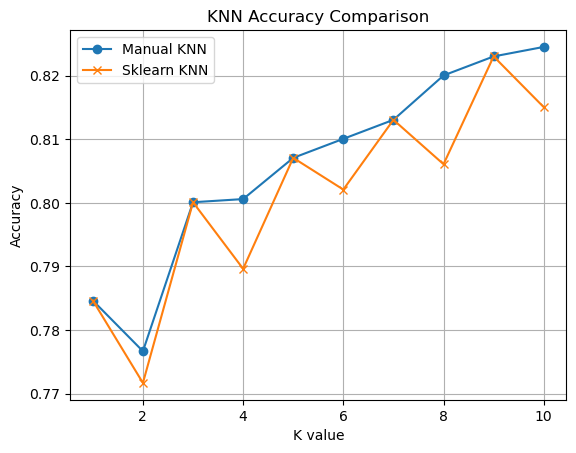

In [58]:
plot_accuracies(k_values, manual_accuracies, sklearn_accuracies)

# Comparisons
## Manual Implementation:
### The manual KNN achieved nearly identical results to the sklearn model. This verifies that the Euclidean distance calculation, sorting, and majority voting logic were implemented correctly.

## Sklearn Implementation:
### The sklearn model is more optimized and faster to train/evaluate. It also provides built-in handling for distance weighting and parameter tuning if needed.

# Overfitting and Underfitting Trends

## Low k (1–3):
###   The classifier fits very tightly to the training data and reacts strongly to individual noisy points.
###   This is a sign of overfitting — the model captures small fluctuations in the training set that don’t generalize well.

## Medium k (5–9):
###   The accuracy improves and stabilizes, showing that the model now considers more neighbors, achieving a good bias-variance balance.
###   This range represents optimal model complexity.

## High k (10+):
###   Accuracy slightly levels off, indicating the start of underfitting — the model becomes smoother and less sensitive to local patterns.
###   However, since performance remains high (~0.82), the model still generalizes well.